<a href="https://colab.research.google.com/github/jgp20/HCSPD2024/blob/main/Actividades_Clase1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Actualizar librerias - instalación

In [ ]:
!apt-get update #Usar para actualizar librerias, únicamente

In [ ]:
!apt install octave #Instala colab en el entorno de trabajo

In [ ]:
# https://gnu-octave.github.io/packages/
# https://github.com/gnu-octave/symbolic
!apt install octave python3-sympy #Instala el paquete simbólico de Octave, que incluye el Sympy de Python

In [ ]:
# Writing Inst_S.m
%%writefile Inst_S.m
pkg install -forge symbolic

In [ ]:
!octave -W Inst_S.m #  corre el código adentro de Octave pkg install -forge symbolic

In [7]:
!pip install --user sympy==1.5.1 #Normalmente no es necesario, pero ésta versión actual de "octave-symbolic" lo exige

In [8]:
%%writefile Graficos_Octave.m
available_graphics_toolkits()

Writing Graficos_Octave.m


In [9]:
!octave -W Graficos_Octave.m

ans =
{
  [1,1] = gnuplot
}





Se debe agregar en el .m el path donde está el Python, mediante una línea como ésta:

setenv PYTHON /usr/local/bin/python

para acceder al sympy desde symbolic. No obtante, puede ser diferente el path y debe verificarse en caso de que no funcione.


#Cálculo simbólico circuito RLC - 1
Valores R=L=C=1 y entrada de tensión escalón de 12V

In [14]:
%%writefile Calculo_RLC_Simbolico.m
clear all; clc;
setenv PYTHON /usr/local/bin/python %Acá está el vinculo con Pyton, para acceder al sympy desde symbolic
%/usr/bin/python
pkg load symbolic %Primera vez que se corre el paquete simbólico de Python.
% #R=1;L=1;C=1; Ve = 12V
syms ii(t) v(t)
% ode1=diff(ii)==-R/L*ii-1/L*v+Ve/L*heaviside(0,1);
% ode2=diff(v)== 1/C ii;
ode1=diff(ii)==-ii-v+ 12*heaviside(0,1);%heaviside(0) devuelve .5
ode2=diff(v)==ii;
cond1 = ii(0) == 0;
cond2 = v(0) == 0;
conds = [cond1;cond2];
odes = [ode1; ode2];
Sol=dsolve(odes,ii(0) == .0,v(0) == .0);
Corriente=simplify(Sol.ii)
Tension=simplify(Sol.v)

Overwriting Calculo_RLC_Simbolico.m


In [15]:
!octave -W Calculo_RLC_Simbolico.m # -W : no window system

Symbolic pkg v3.1.1: Python communication link active, SymPy v1.5.1.
Corriente = (sym)

        -t           
        ───          
         2     ⎛√3⋅t⎞
  8⋅√3⋅ℯ   ⋅sin⎜────⎟
               ⎝ 2  ⎠

Tension = (sym)

             -t               
             ───              
              2     ⎛√3⋅t   π⎞
  12 - 8⋅√3⋅ℯ   ⋅sin⎜──── + ─⎟
                    ⎝ 2     3⎠




SOLUCION ANALITICA
Simular 3 segundos

In [ ]:
%%writefile Solucion_analitica_1.m
%Para valores unitarios L=R=C=1 y alimentacion escalon unitario
clc;clear all;
warning('off','all');
color_='r';
color='b';
X=-[0; 0];ii=0;
t_etapa=1e-3;tF=3;
wRef=2;
Ts=t_etapa;
t=0:t_etapa:tF;
for t=0:t_etapa:tF
  ii=ii+1;
  acc(ii)=u;
end
x1_analitica = (2.*sqrt(3) .* exp(-t/2) .* sin ( sqrt(3).*t / 2))/3;
x2_analitica = 1-(2.*sqrt(3) .* exp(-t/2) .* sin ( sqrt(3).*t / 2 +pi/3))/3;
hfig1 = figure(1); set(hfig1, 'Visible', 'off');
subplot(3,1,1);hold on;
plot(t,x1_analitica,color);title('x_1 corriente'); hold on;
subplot(3,1,2);hold on;
plot(t,x2_analitica,color_);title('x_2 Vc_t');
subplot(3,1,3);hold on;
plot(t,acc,color_);title('Entrada u_t, v_a');
xlabel('Tiempo [Seg.]');
print(hfig1,'Vars_temporal','-r300','-dpng');
save('Solucion_analitica_1.mat','-v7');

Overwriting Solucion_analitica_1.m


In [ ]:
# -W : no window system
!octave -W Solucion_analitica.m
import scipy.io
mat = scipy.io.loadmat('/content/Solucion_analitica_1.mat');

x1_analitica =

 Columns 1 through 8:

        0   0.0950   0.1801   0.2553   0.3210   0.3773   0.4248   0.4636

 Columns 9 through 16:

   0.4944   0.5175   0.5335   0.5429   0.5463   0.5441   0.5370   0.5254

 Columns 17 through 24:

   0.5100   0.4911   0.4694   0.4453   0.4193   0.3917   0.3631   0.3337

 Columns 25 through 31:

   0.3039   0.2741   0.2445   0.2154   0.1871   0.1596   0.1332

x2_analitica =

 Columns 1 through 8:

   1.0000   0.9050   0.8199   0.7447   0.6790   0.6227   0.5752   0.5364

 Columns 9 through 16:

   0.5056   0.4825   0.4665   0.4571   0.4537   0.4559   0.4630   0.4746

 Columns 17 through 24:

   0.4900   0.5089   0.5306   0.5547   0.5807   0.6083   0.6369   0.6663

 Columns 25 through 31:

   0.6961   0.7259   0.7555   0.7846   0.8129   0.8404   0.8668

error: 'acc' undefined near line 16, column 16
error: called from
    Solucion_analitica at line 16 column 1


FileNotFoundError: [Errno 2] No such file or directory: '/content/Solucion_analitica_1.mat'

In [ ]:
from PIL import Image
imt = Image.open("/content/Vars_temporal.png")
imt

FileNotFoundError: [Errno 2] No such file or directory: '/content/Vars_temporal.png'

# Verificación numérica - 1

In [ ]:
%%writefile Verificacion_Num_1.m
clc;clear all;
warning('off','all');
X=-[0; 0];ii=0;
t_etapa=1e-3;tF=3;
wRef=2;
color_='r';
color='b';
%Ts=t_etapa;
%A1=((2*Kp*Ts)+(Ki*(Ts^2))+(2*Kd))/(2*Ts);
%B1=(-2*Kp*Ts+Ki*(Ts^2)-4*Kd)/(2*Ts);
%C1=Kd/Ts;
%e=zeros(round(tF/t_etapa),1);
u=0;
%TL=1.15e-4;
u=1;
%graphics_toolkit("gnuplot"); %No aconsejado
%graphics_toolkit("fltk");
%graphics_toolkit("qt"); %Aconsejado
% x1(1)=X(1);%corriente
% x2(2)=X(2);%tensión en el capacitor
for t=0:t_etapa:tF
  ii=ii+1;
  %k=ii+2;
  x1(ii)=X(1);%corriente
  x2(ii)=X(2);%tensión en el capacitor
  X=modrlc(t_etapa, X, u);
  acc(ii)=u;
end
t=0:t_etapa:tF;
hfig1 = figure(1); set(hfig1, 'Visible', 'off');
subplot(3,1,1);hold on;
plot(t,x1,color);title('x_1 corriente'); hold on;
subplot(3,1,2);hold on;
plot(t,x2,color_);title('x_2 Vc_t');
subplot(3,1,3);hold on;
plot(t,acc,color_);title('Entrada u_t, v_a');
xlabel('Tiempo [Seg.]');
print(hfig1,'Vars_temporal','-r300','-dpng');
save('Verificacion_Num_1.mat','-v7');

Overwriting Verificacion_Num_1.m


In [ ]:
%%writefile modrlc.m
%Funcion modelo
function [X]=modrlc(t_etapa, xant, accion)
h=1e-4;
%t_simul=1e-3;
R=1;L=1;C=1;
A=[-R/L, -1/L;1/C,0];B=[1/L;0];%
% eig(A)
% 1./ans
C=[R 0];u=accion;
x=xant;
for ii=1:t_etapa/h
xp=A*x+B*u;
x=x+xp*h;
end
X=[x];%x1 corriente, x2 tensión

Overwriting modrlc.m


# Graficos

In [ ]:
# -W : no window system
!octave -W Verificacion_Num_1.m
import scipy.io
mat = scipy.io.loadmat('/content/Verificacion_Num_1.mat')

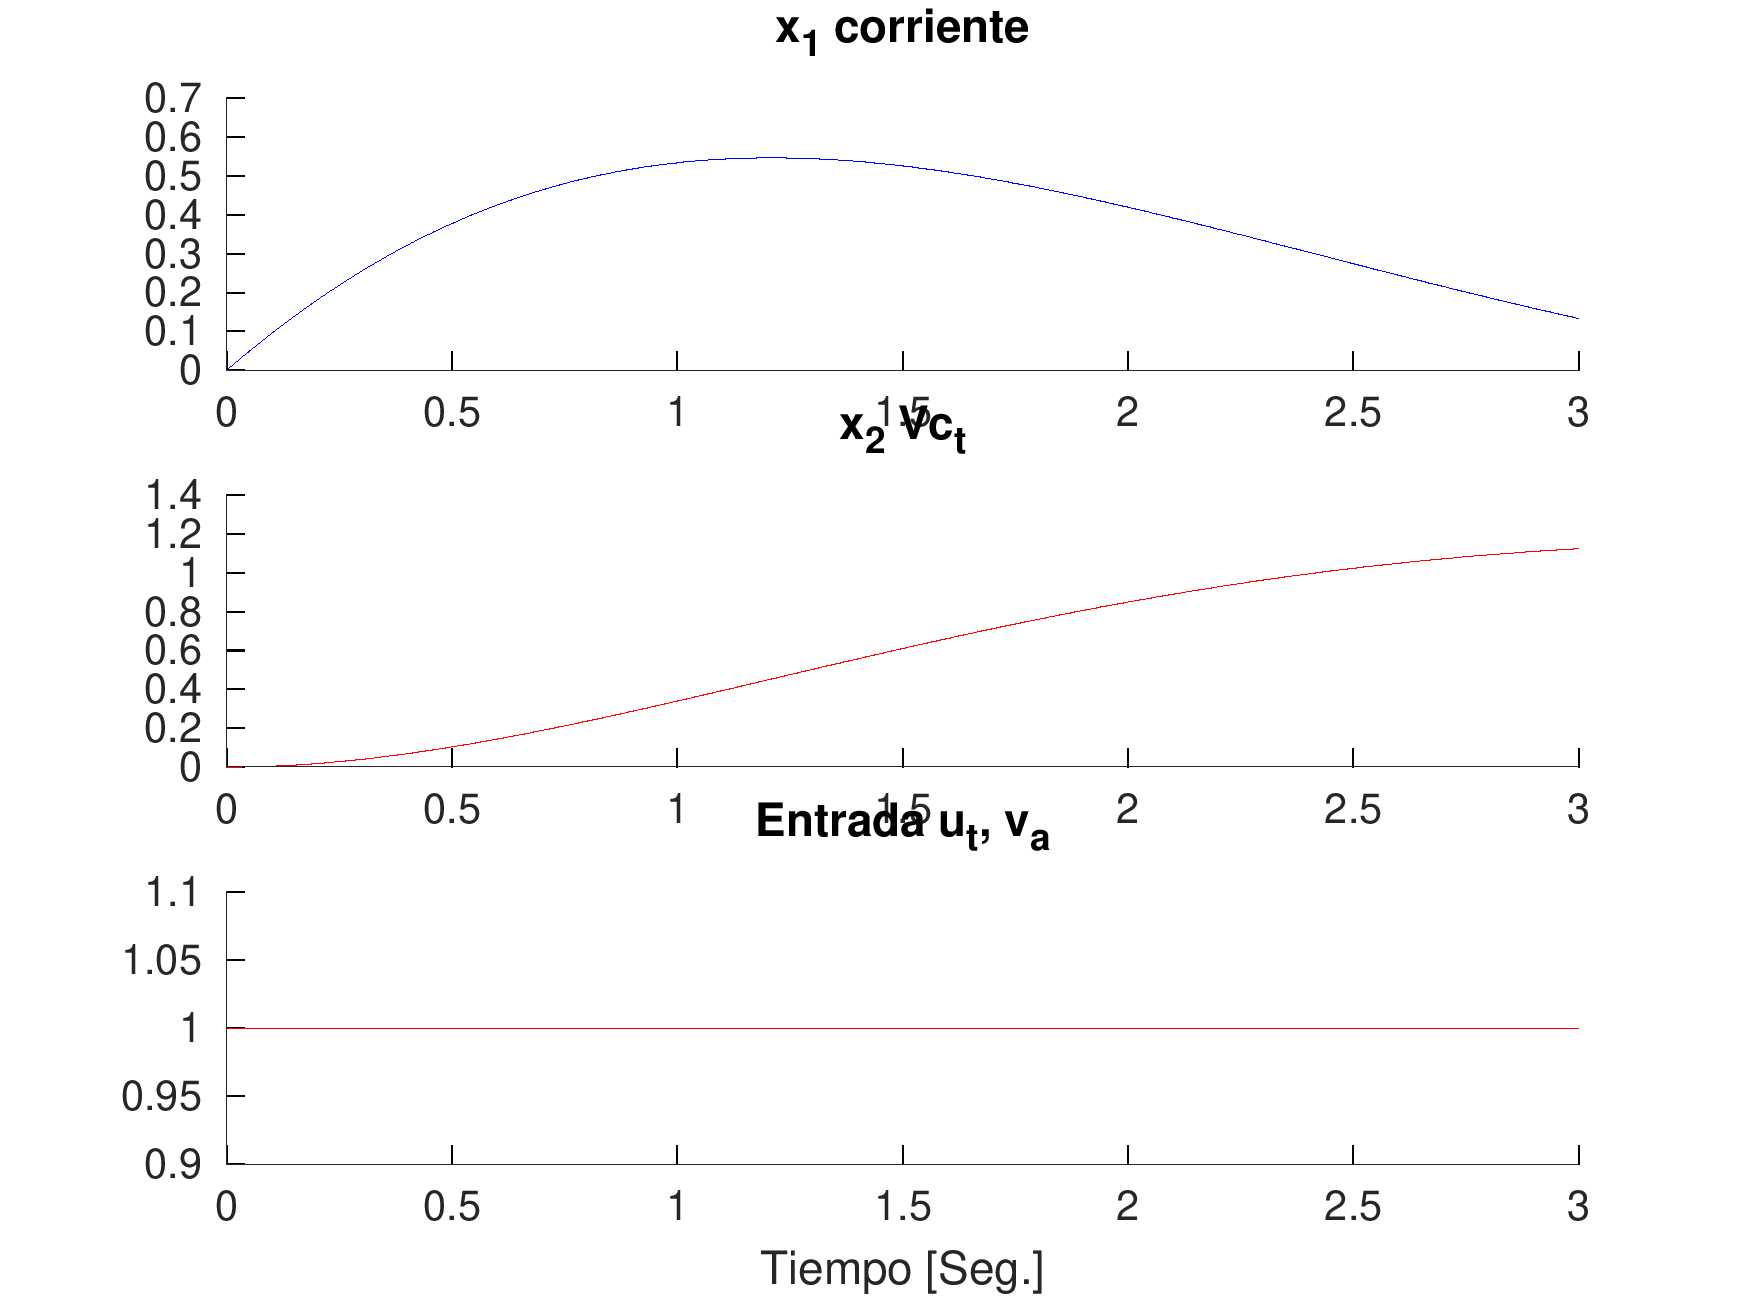

In [ ]:
from PIL import Image
imt = Image.open("/content/Vars_temporal.png")
imt

GUARDAR EN GOOGLE

In [ ]:
from google.colab import drive #ésto es para guardar los resultados en el Gdrive.
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
# !cp Vars_temporal.png /content/drive/MyDrive/CursoHCSPD2024 #Copia uno por uno
import os
import shutil
fnames = ['Vars_temporal.png','Solucion_analitica_1.m','Verificacion_Num_1.m','Verificacion_Num_1.mat','modrlc.m'] #Acá van los nombres de los archivos que desean copiarse al Gdrive
for fname in fnames:
  src = os.path.join('/content', fname)
  dst = os.path.join('/content/drive/MyDrive/CursoHCSPD2024', fname)
  shutil.copyfile(src, dst)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/CursoHCSPD2024/Vars_temporal.png'